# Customer Churn Model

### Customer Retention Retail Dataset

This dataset can be used to understand what are the various marketing strategy based on consumer behaviour that can be adopted to increase customer retention of a retail store.

An online tea retail store which sells tea of different flavors across various cities in India. The dataset contains data about the store's customers, their orders, quantity ordered, order frequency, city,etc. This is a large dataset which will help in analysis.

### Import Packages and Constants

Import relevant packages

In [1]:
!conda install -c conda-forge shap --yes

Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
doneecting package metadata (repodata.json): - 
| lving environment: | 

In [2]:
!pip install smdebug --upgrade

In [3]:
!pip install imblearn

In [4]:
!pip install scikit-learn

In [6]:
!conda update packaging

Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
doneecting package metadata (repodata.json): - 
doneing environment: - 


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [7]:
!pip install xgboost

In [8]:
import re
import s3fs
import shap
import time
import boto3
import io
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
import matplotlib.pyplot as plt
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import xgboost as xgboost
import warnings
warnings.filterwarnings('ignore')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/19/25 06:06:53] INFO     Found credentials from IAM Role:                                   ]8;id=725564;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=843901;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


### Defining IAM role and s3 bucket

In [9]:
# Defining the bucket
default_bucket = "churn-s3-bucket"

In [10]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

[03/19/25 06:07:19] INFO     Found credentials from IAM Role:                                   ]8;id=784499;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=452269;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[03/19/25 06:07:20] INFO     Found credentials from IAM Role:                                   ]8;id=446566;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=453627;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

### Loading and Processing Data

In [11]:
# Sourcing original data
data = pd.read_excel(f"s3://{default_bucket}/storedata_total.xlsx")
data

[03/19/25 06:07:43] INFO     Found credentials from IAM Role:                                   ]8;id=706194;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=489298;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday,city
0,6H6T6N,0,2012-09-28,2013-08-11 00:00:00,2013-08-11 00:00:00,29,100.000000,3.448276,14.52,0.000000,0,0,0,Monday,DEL
1,APCENR,1,2010-12-19,2011-04-01 00:00:00,2014-01-19 00:00:00,95,92.631579,10.526316,83.69,0.181641,1,1,1,Friday,DEL
2,7UP6MS,0,2010-10-03,2010-12-01 00:00:00,2011-07-06 00:00:00,0,0.000000,0.000000,33.58,0.059908,0,0,0,Wednesday,DEL
3,7ZEW8G,0,2010-10-22,2011-03-28 00:00:00,2011-03-28 00:00:00,0,0.000000,0.000000,54.96,0.000000,0,0,0,Thursday,BOM
4,8V726M,1,2010-11-27,2010-11-29 00:00:00,2013-01-28 00:00:00,30,90.000000,13.333333,111.91,0.008850,0,0,0,Monday,BOM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30796,24CY2D,1,2018-01-17,2018-01-17 00:00:00,2018-01-17 00:00:00,6,83.333333,16.666667,55.68,0.000000,1,0,1,Friday,MAA
30797,YQK8BU,1,2018-01-17,2018-01-17 00:00:00,2018-01-17 00:00:00,13,69.230769,7.692308,35.00,0.000000,1,0,0,Saturday,MAA
30798,TFQRQP,1,2018-01-17,2018-01-17 00:00:00,2018-01-21 00:00:00,8,75.000000,37.500000,52.03,0.500000,1,1,0,Saturday,MAA
30799,ZTXM5Y,1,2018-01-17,2018-01-17 00:00:00,2018-01-17 00:00:00,6,33.333333,0.000000,40.20,0.000000,1,0,0,Friday,BOM


In [13]:
def preprocess_data(file_path):
    df = pd.read_excel(file_path)

    # Convert to datetime columns
    df["firstorder"] = pd.to_datetime(df["firstorder"], errors = 'coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"], errors = 'coerce')

    # Drop Rows with null values
    df = df.dropna()

    # Create Column which gives the days between the last order and the first order
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days

    # Create Column which gives the days between when the customer record was created and the first order
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff']=(df['firstorder']-df['created']).dt.days

    # Drop Columns
    df.drop(['custid', 'created', 'firstorder', 'lastorder'], axis=1, inplace=True)

    # Apply one hot encoding on favday and city columns
    df = pd.get_dummies(df, prefix=['favday', 'city'], columns = ['favday', 'city'])
    return df

In [14]:
storedata = preprocess_data(f"s3://{default_bucket}/storedata_total.xlsx")
storedata.head()

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,0,0,0,0,0,1,0,0,1,0
3,0,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,1,30,90.000000,13.333333,111.91,0.008850,0,0,0,791,...,1,0,0,0,0,0,0,1,0,0


In [15]:
# Balancing dataset
def balance_data(df, target): 
    y = df.pop(target)
    X = df
    column_names = ['retained'] + list(X.columns)
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.15, random_state = 10)

    # Concatenating test data
    test_data = pd.concat([y_test, X_test], axis=1)

    # Balancing data using smote
    smote = SMOTE(random_state = 10)
    X_resampled, y_resampled = smote.fit_resample(X_temp, y_temp)

    # Concating validation and training set 
    X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size = 0.20, random_state = 10)
    val_data = pd.concat([y_val, X_val], axis=1)
    train_data = pd.concat([y_train, X_train], axis=1)
    
    return train_data, val_data, test_data, column_names

In [16]:
train, validation, test, column_names = balance_data(storedata, 'retained')

In [17]:
train.to_csv(f"s3://{default_bucket}/data/train/train.csv",header=False,index=False)
validation.to_csv(f"s3://{default_bucket}/data/validation/validation.csv",header=False,index=False)
test.to_csv(f"s3://{default_bucket}/data/test/test.csv",header=False,index=False)

### Specifying loacations

In [18]:
# Define the S3 paths
train_location = f's3://{default_bucket}/data/train/train.csv'
validation_location = f's3://{default_bucket}/data/validation/validation.csv'
test_location = f's3://{default_bucket}/data/test/test.csv'

### Builing SageMaker Model

In [19]:
# Define the XGBoost container
container = sagemaker.image_uris.retrieve('xgboost', sagemaker.Session().boto_region_name, version='1.5-1')

[03/19/25 06:09:37] INFO     Found credentials from IAM Role:                                   ]8;id=873222;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=187979;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=553818;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=734042;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [20]:
# Set up the XGBoost estimator
xgb = sagemaker.estimator.Estimator(
    image_uri=container,
    role = sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m5.xlarge',
    output_path=f's3://{default_bucket}/output',
    sagemaker_session=Session(),
    hyperparameters={
        "num_round": "100",
        "objective": "binary:logistic", 
        "eval_metric": 'auc', # Internal evaluation metric
        'early_stopping_rounds': 10 #early stopping
    },
)

[03/19/25 06:09:46] INFO     Found credentials from IAM Role:                                   ]8;id=888335;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=223989;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=571745;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=709657;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=772762;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=815273;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [21]:
# Prepare input data channels
train_input = TrainingInput(s3_data=train_location, content_type='csv')
validation_input = TrainingInput(s3_data=validation_location, content_type='csv')

In [22]:
# Training the model
xgb.fit({'train': train_input, 'validation': validation_input})

[03/19/25 06:10:08] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=819739;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=653996;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=549532;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=953727;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-03-19-06-10-08-915                                             

2025-03-19 06:10:09 Starting - Starting the training job......
..25-03-19 06:10:56 Starting - Preparing the instances for training.
.....03-19 06:11:42 Downloading - Downloading the training image.
2025-03-19 06:12:44 Training - Training image download completed. Training in progress.
/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-03-19 06:12:40.147 ip-10-0-204-65.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-03-19 06:12:40.169 ip-10-0-204-65.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-03-19:06:12:40:INFO] Imported framework sagemaker_xgboost_container.training
[2025-03-19:06:12:40:INFO] Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
[2025-03-19:06:12:40:INFO] F

#### Model is 99% accurate on the validation data 

### Examining Feature Importance using XGBOOST 

In [23]:
y_train = train.pop('retained')
X_train = train 

In [24]:
# Create DMatrix (XGBoost's data structure)
import xgboost as xgboost
dtrain = xgboost.DMatrix(X_train, label=y_train)

# Set hyperparameters
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'merror',
}

In [25]:
# Train the model
model = xgboost.train(params, dtrain, num_boost_round=100)

In [26]:
# Dataframe of feature importance and gain
importance_gain = model.get_score(importance_type='gain')
importance_gain_df = pd.DataFrame(list(importance_gain.items()), columns=['Feature', 'Gain'])
importance_gain_df = importance_gain_df.sort_values(by='Gain', ascending=False)
print(importance_gain_df)

                    Feature       Gain
0                     esent  52.863079
5                 paperless  13.305480
10            favday_Friday  11.595154
19                 city_DEL  10.700325
17                 city_BLR  10.602181
15           favday_Tuesday   8.737014
11            favday_Monday   7.803506
18                 city_BOM   7.401266
20                 city_MAA   7.210456
6                    refill   7.130104
12          favday_Saturday   6.754821
14          favday_Thursday   6.272927
16         favday_Wednesday   5.804151
13            favday_Sunday   4.222229
2                eclickrate   2.860501
7                  doorstep   2.830690
8      first_last_days_diff   2.455559
1                 eopenrate   2.323020
9   created_first_days_diff   1.740760
3                  avgorder   1.303845
4                   ordfreq   1.074253


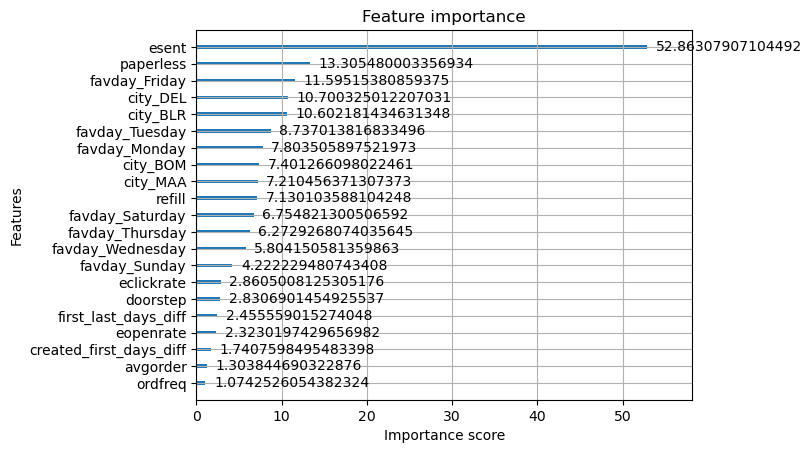

In [27]:
xgboost.plot_importance(model, importance_type='gain')
plt.show()

#### esent is overwhelmingly the most important feature

### Deploy SageMake Model

In [29]:
# Deploy the model
predictor = xgb.deploy(instance_type='ml.m5.large', initial_instance_count=1)

[03/19/25 06:19:57] INFO     Creating model with name: sagemaker-xgboost-2025-03-19-06-19-57-446    ]8;id=288458;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=280162;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[03/19/25 06:19:58] INFO     Creating endpoint-config with name                                     ]8;id=257496;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=977573;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\
                             sagemaker-xgboost-2025-03-19-06-19-57-446                                             

                    INFO     Creating endpoint with name sagemaker-xgboost-2025-03-19-06-19-57-446  ]8;id=840492;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=886507;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

---------!

In [30]:
sample = test.loc[20605]  # Get the 1 row

# Convert DataFrame to CSV string
csv_buffer = io.StringIO() #create a string buffer.
sample.to_csv(csv_buffer, index=False, header=False) #Convert to csv.
csv_string = csv_buffer.getvalue() #get the string value.

print(csv_string)

0.0
23.0
34.7826087
26.08695652
40.02
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0



In [31]:
# Inference
predictor.content_type = 'text/csv' 
response = predictor.predict(csv_string)
print(response)

b'1.6072153812274337e-05\n0.011612895876169205\n0.02908378280699253\n0.014962609857320786\n0.16433212161064148\n1.6072153812274337e-05\n1.6072153812274337e-05\n1.6072153812274337e-05\n1.6072153812274337e-05\n1.6072153812274337e-05\n1.6072153812274337e-05\n1.6072153812274337e-05\n1.6072153812274337e-05\n1.6072153812274337e-05\n1.6072153812274337e-05\n1.6072153812274337e-05\n1.6072153812274337e-05\n1.6072153812274337e-05\n1.6072153812274337e-05\n1.6072153812274337e-05\n1.6072153812274337e-05\n1.6072153812274337e-05\n'


In [32]:
response_string = response.decode('utf-8')  # Decode the byte string
probabilities = [float(p) for p in response_string.strip().split('\n')]  # Convert to floats

threshold = 0.5  # Set your threshold
predictions = [1 if p >= threshold else 0 for p in probabilities]  # Apply threshold

pred_df = pd.DataFrame({'feature': column_names[1:], 'prediction': predictions[1:]})
print(pred_df)

                    feature  prediction
0                     esent           0
1                 eopenrate           0
2                eclickrate           0
3                  avgorder           0
4                   ordfreq           0
5                 paperless           0
6                    refill           0
7                  doorstep           0
8      first_last_days_diff           0
9   created_first_days_diff           0
10            favday_Friday           0
11            favday_Monday           0
12          favday_Saturday           0
13            favday_Sunday           0
14          favday_Thursday           0
15           favday_Tuesday           0
16         favday_Wednesday           0
17                 city_BLR           0
18                 city_BOM           0
19                 city_DEL           0
20                 city_MAA           0


In [ ]:
predictor.delete_endpoint()